In [24]:
from data_service import DataServiceTushare
from logger import Logger
import tushare as ts
from time import time, sleep
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.metrics import recall_score, confusion_matrix, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from pymongo import MongoClient, ASCENDING, DESCENDING

In [346]:
ds_tushare = DataServiceTushare()    
lst_index_price = ds_tushare.getStockPriceLst('000001_SH', '20030301')
count_X = lst_index_price.count()
data_index = np.zeros(shape=(count_X, 4))    
data_index_data = list()
lst_index_price.sort("trade_date", DESCENDING)
last_index_val = 0.0
idx = 0
for item in lst_index_price:
    ma5 = item['close'] - item['ma_5']
    ma20 = item['close'] - item['ma_20']        
    ma10 = item['close'] - item['ma_10']     
    ma30 = item['close'] - item['ma_30']        
    ma60 = item['close'] - item['ma_60']        
    ma120 = item['close'] - item['ma_120']        
    ma250 = item['close'] - item['ma_250']            
    vol_rate = item['vol_rate']
    result = 1 if item['close'] <= last_index_val else 0
    # data_index[idx] = [ma5, ma10, ma20, ma30, ma60, ma120, ma250, vol_rate, result]  
    data_index[idx] = [ma5, ma20, vol_rate, result]  
    data_index_data.append(item['trade_date'])      
    idx += 1
    last_index_val = item['close']
X_train, X_test, y_train, y_test = train_test_split(data_index[:, :-1], data_index[:, -1], test_size=0.1)

In [390]:
pipe = Pipeline([('standard_scaler', StandardScaler()), 
                ('polynomial_features', PolynomialFeatures(degree=2)), 
                ('logistic_reg', LogisticRegressionCV(cv=5 ,class_weight={0:0.55, 1:0.45}))],)    

In [395]:
from sklearn.ensemble import BaggingClassifier
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
svc_clf = SVC(kernel='rbf', gamma=5, C=0.001)

In [399]:
bag_clf = BaggingClassifier(svc_clf, n_estimators=500, max_samples=0.2, bootstrap=True, n_jobs=-1, oob_score=True)

In [400]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=SVC(C=0.001, break_ties=False, cache_size=200,
                                     class_weight=None, coef0=0.0,
                                     decision_function_shape='ovr', degree=3,
                                     gamma=5, kernel='rbf', max_iter=-1,
                                     probability=False, random_state=None,
                                     shrinking=True, tol=0.001, verbose=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=0.2, n_estimators=500, n_jobs=-1, oob_score=True,
                  random_state=None, verbose=0, warm_start=False)

In [401]:
bag_clf.oob_score_

0.5291118862355783

In [65]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.5010266940451745

In [9]:
y_pred

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0.])

In [338]:
pipe_svc = Pipeline([('standard_scaler', StandardScaler()),                 
                ('svc', SVC(kernel='rbf', gamma=5, C=0.001))],)    

In [339]:
bag_clf = BaggingClassifier(pipe_svc, n_estimators=100, max_samples=0.8, bootstrap=True, n_jobs=-1, oob_score=True)

In [340]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=Pipeline(memory=None,
                                          steps=[('standard_scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True)),
                                                 ('svc',
                                                  SVC(C=0.001, break_ties=False,
                                                      cache_size=200,
                                                      class_weight=None,
                                                      coef0=0.0,
                                                      decision_function_shape='ovr',
                                                      degree=3, gamma=5,
                                                      kernel='rbf', max_iter=-1,
                                                    

In [341]:
bag_clf.oob_score_

0.5334048832841427

In [342]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.5012048192771085

In [23]:
data_index

array([[-123.8353    , -186.96927   ,    0.95902885,    0.        ],
       [ -56.4699    ,  -98.514905  ,    1.0011386 ,    0.        ],
       [ -49.82776   ,  -63.934865  ,    0.7820307 ,    0.        ],
       ...,
       [  24.3786    ,  109.9385    ,    1.08888958,    0.        ],
       [  20.6606    ,   98.5783    ,    0.90469388,    1.        ],
       [  21.1316    ,   95.61585   ,    1.07101998,    1.        ]])

In [33]:
data_index_data[-4000:-3994]

['20160825', '20160824', '20160823', '20160822', '20160819', '20160818']

In [34]:
data_index[-4000:-3994]

array([[-19.0354    ,  26.8631    ,   0.94978451,   1.        ],
       [ -8.6414    ,  48.1144    ,   0.74015537,   0.        ],
       [ -9.5504    ,  56.63445   ,   0.73265405,   0.        ],
       [-18.5176    ,  53.71045   ,   0.76386159,   1.        ],
       [ -3.2986    ,  80.4563    ,   0.81843063,   0.        ],
       [  4.2004    ,  81.2326    ,   1.0240724 ,   1.        ]])

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
x2d = pca.fit_transform(X_train)

In [52]:
pca.explained_variance_ratio_

array([8.66836641e-01, 1.00605942e-01, 2.24948093e-02, 6.39546964e-03,
       2.72543197e-03, 6.45098853e-04, 2.96495911e-04, 1.11695155e-07])

In [54]:
pca.

8

In [66]:
import matplotlib.pyplot as plt

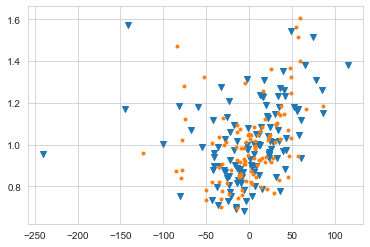

In [81]:
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], marker='v')
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], marker='.')

In [80]:
len(y_train)

228

In [333]:
# knn训练股票模型
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [334]:
standard_scale = StandardScaler()
standard_scale.fit_transform(X_train)
ftwo_scorer = make_scorer(accuracy_score)
knn_clf = KNeighborsClassifier()
params = {'n_neighbors':[i+1 for i in range(15)], 'weights':['distance', 'uniform'], 'metric':['minkowski'], 'p':[i+1 for i in range(15)]}
grid_cv = GridSearchCV(knn_clf, param_grid=params, cv=5, n_jobs=-1, scoring=ftwo_scorer)
grid_cv.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15],
                         'p': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                               15],
                         'weights': ['distance', 'uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(accuracy_score), verbose=0)

In [335]:
accuracy_score(y_test, grid_cv.predict(standard_scale.transform(X_test)))

0.4843373493975904

In [336]:
grid_cv.best_score_

0.5304557640750671

In [337]:
grid_cv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=7,
                     weights='uniform')

In [253]:
bag_clf = BaggingClassifier(grid_cv.best_estimator_, n_estimators=200, max_samples=0.8, bootstrap=True, n_jobs=-1, oob_score=True)

In [254]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto',
                                                      leaf_size=30,
                                                      metric='minkowski',
                                                      metric_params=None,
                                                      n_jobs=None,
                                                      n_neighbors=12, p=10,
                                                      weights='distance'),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=0.8, n_estimators=200, n_jobs=-1, oob_score=True,
                  random_state=None, verbose=0, warm_start=False)

In [255]:
accuracy_score(y_test, bag_clf.predict(standard_scale.transform(X_test)))

0.5318275154004107

In [256]:
bag_clf.oob_score_

0.5181714285714286

In [259]:
from data_service import DataServiceTushare
from logger import Logger
import tushare as ts
from time import time, sleep
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import recall_score, confusion_matrix, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
import numpy as np
import pandas as pd
from pymongo import MongoClient, ASCENDING, DESCENDING
        
ds_tushare = DataServiceTushare()    
# lst_index_price = ds_tushare.getStockPriceLst('000001_SH', '20000301')
lst_index_price = ds_tushare.getStockPriceLst('399001_SZ', '20000301')
# data_index = np.zeros(shape=(len(lst_index_price), 4))    
count_X = lst_index_price.count()
data_index = np.zeros(shape=(count_X, 4))    
lst_index_price.sort("trade_date", DESCENDING)
last_index_val = 0.0
idx = 0
for item in lst_index_price:
    ma5 = item['close'] - item['ma_5']
    ma20 = item['close'] - item['ma_20']        
    vol_rate = item['vol_rate']
    result = 1 if item['close'] <= last_index_val else 0
    data_index[idx] = [ma5, ma20, vol_rate, result]        
    idx += 1
    last_index_val = item['close']
X_train, X_test, y_train, y_test = train_test_split(data_index[:, :-1], data_index[:, -1], test_size=0.3)    
pipe = Pipeline([('standard_scaler', StandardScaler()), 
                ('polynomial_features', PolynomialFeatures(degree=2)), 
                ('logistic_reg', LogisticRegressionCV(cv=10, class_weight={0:0.55, 1:0.45}, n_jobs=-1))])        
pipe.fit(X_train, y_train)
y_predict_sz = pipe.predict(X_test)




In [261]:
ds_tushare = DataServiceTushare()    
lst_index_price = ds_tushare.getStockPriceLst('000001_SH', '20000301')
# lst_index_price = ds_tushare.getStockPriceLst('399001_SZ', '20000301')
# data_index = np.zeros(shape=(len(lst_index_price), 4))    
count_X = lst_index_price.count()
data_index = np.zeros(shape=(count_X, 4))    
lst_index_price.sort("trade_date", DESCENDING)
last_index_val = 0.0
idx = 0
for item in lst_index_price:
    ma5 = item['close'] - item['ma_5']
    ma20 = item['close'] - item['ma_20']        
    vol_rate = item['vol_rate']
    result = 1 if item['close'] <= last_index_val else 0
    data_index[idx] = [ma5, ma20, vol_rate, result]        
    idx += 1
    last_index_val = item['close']
X_train, X_test, y_train, y_test = train_test_split(data_index[:, :-1], data_index[:, -1], test_size=0.3)    
pipe = Pipeline([('standard_scaler', StandardScaler()), 
                ('polynomial_features', PolynomialFeatures(degree=2)), 
                ('logistic_reg', LogisticRegressionCV(cv=10, class_weight={0:0.55, 1:0.45}, n_jobs=-1))])        
pipe.fit(X_train, y_train)
y_predict_sh = pipe.predict(X_test)

In [271]:
y_predict = np.array((y_predict_sh == y_predict_sz) & (y_predict_sz == 1), dtype=int)

In [272]:
precision_score(y_test, y_predict)

0.5757575757575758

In [276]:
len(X_train[y_train==1]) / len(X_train[y_train==1])

0.5312

In [277]:
X_up = X_train[y_train==1]

In [297]:
len(X_up[X_up[:,7]>0.8]) / len(X_up)

0.8347676419965576

In [313]:
X_ma5 = X_train[X_train[:,0]>0.0]
y_ma5 = y_train[X_train[:,0]>0.0]
X_ma10 = X_train[X_train[:,1]>0.0]
y_ma10 = y_train[X_train[:,1]>0.0]
X_ma20 = X_train[X_train[:,2]>0.0]
y_ma20 = y_train[X_train[:,2]>0.0]
X_ma30 = X_train[X_train[:,3]>0.0]
y_ma30 = y_train[X_train[:,3]>0.0]
X_ma60 = X_train[X_train[:,4]>0.0]
y_ma60 = y_train[X_train[:,4]>0.0]
X_rate = X_train[X_train[:,7]>1.0]
y_rate = y_train[X_train[:,7]>1.0]


In [305]:
len(X_ma5[y_ma5==1]) / len(X_ma5)

0.5397653194263363

In [306]:
len(X_ma10[y_ma10==1]) / len(X_ma10)

0.5422260718925942

In [307]:
len(X_ma20[y_ma20==1]) / len(X_ma20)

0.5651052857756769

In [308]:
len(X_ma30[y_ma30==1]) / len(X_ma30)

0.5618466898954704

In [309]:
len(X_ma60[y_ma60==1]) / len(X_ma60)

0.5677852348993289

In [315]:
len(X_rate[y_rate==1]) / len(X_rate)

0.543247344461305

In [320]:
X_ma20_rate = X_train[(X_train[:,2]>0.0) & (X_train[:,7]>1.0)]

In [321]:
y_ma20_rate = y_train[(X_train[:,2]>0.0) & (X_train[:,7]>1.0)]

In [324]:
len(X_ma20_rate[y_ma20_rate==1]) / len(X_ma20_rate)

0.5833998403830806

In [347]:
pipe_svc = Pipeline([('standard_scaler', StandardScaler()), ('svc', SVC(kernel='rbf', gamma=5, C=0.001))],)
pipe_svc.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('standard_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [348]:
accuracy_score(y_test, pipe_svc.predict(X_test))

0.5397590361445783

In [383]:
#用逻辑回归，朴素贝叶斯和svm集成学习
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
gnb_clf = GaussianNB()
svc_clf = SVC(kernel='rbf', gamma=5, C=0.001)
pipe_log = Pipeline([
                ('polynomial_features', PolynomialFeatures(degree=2)), 
                ('logistic_reg', LogisticRegressionCV(cv=10, class_weight={0:0.55, 1:0.45}, n_jobs=-1))]) 

In [384]:
voting_clf = VotingClassifier(estimators=[('svc', svc_clf), ('log', pipe_log), ('bayes', gnb_clf)], voting='hard')

In [385]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svc',
                              SVC(C=0.001, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=5, kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('log',
                              Pipeline(memory=None,
                                       steps=[('polynomial_features',
                                               PolynomialFeatures(degree=2,
                                                                  include...
                                                                                  1: 0.45},
                                                                    cv=10,
                                                

In [386]:
accuracy_score(y_test, voting_clf.predict(standard_scaler.transform(X_test)))

0.5397590361445783

In [389]:
for clf in (svc_clf, pipe_log, gnb_clf):
    clf.fit(X_train, y_train)
    y_predict = clf.predict(standard_scaler.transform(X_test))    
    print(accuracy_score(y_test, y_predict))

0.5397590361445783
0.5228915662650603
0.5397590361445783
